In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.constants import R_sun, L_sun

import seaborn as sns
sns.set(font_scale=1.7, style='whitegrid', palette='dark', rc={'font.weight': 'medium'})

col = sns.color_palette()
lines = ['-', '--', '-.', ':', '-']

%matplotlib inline

## Part 2: Stellar Evolution

### Read the MESA outputs (at fixed solar metallicity).

In [5]:
zz = 'Z0.02' # fixed metallicity
mass = np.array((0.5, 1.0, 3.0, 8.0, 15.0))
massfile = ['M{:.1f}'.format(mm) for mm in mass]
nmodel = len(massfile)

age = list()
teff = list()
lum = list()
l3alpha = list()
tc = list()
rhoc = list()
#rand = list()
hshell = np.zeros(nmodel).astype('int')-1
hecore = np.zeros(nmodel).astype('int')-1

for ii, mm in enumerate(massfile):
    ff = os.path.join(mm, zz, 'trimmed_history.data')
    print('Reading {}'.format(ff))
    cat = np.loadtxt(ff, skiprows=6)
    HI = cat[:, 10] 
    keep = np.where((HI[0] - HI) > 3E-3)[0]
    age.append(cat[keep, 1] / 1E9)
    teff.append(cat[keep, 5])
    lum.append(cat[keep, 3])
    l3alpha.append(cat[keep, 22])
    tc.append(cat[keep, 6])
    rhoc.append(cat[keep, 7] + np.log10(1E3)) # [kg/m3]
    
    # To find when H-shell burning starts use Column 29, the "Radius of outermost
    # region where the Helium 4 mass fraction is greater than 0.01."
    here = np.where(cat[keep, 28] > 0)[0]
    if len(here) > 0:
        hshell[ii] = here[0]
    # To get the point of helium ignition use Column 22, the luminosity of the 3-alpha process.
    here = np.where(cat[keep, 22] > 0)[0]
    if len(here) > 0:
        hecore[ii] = here[0]
        
    #rand.append(cat[keep, 6])

Reading M0.5/Z0.02/trimmed_history.data
Reading M1.0/Z0.02/trimmed_history.data
Reading M3.0/Z0.02/trimmed_history.data
Reading M8.0/Z0.02/trimmed_history.data
Reading M15.0/Z0.02/trimmed_history.data


In [4]:
print(l3alpha)

[array([-57.50367925, -57.55595192, -57.61123486, ...,  -9.75761115,
        -9.75621231,  -9.75481669]), array([-47.28456197, -47.28147693, -47.27917851, ...,  -8.00354806,
        -8.00232327,  -8.00109564]), array([-35.81770002, -35.80992258, -35.80359852, ...,   2.20107182,
         2.19773025,   2.1944142 ]), array([-31.46506799, -31.47113467, -31.47691579, ...,   3.62018819,
         3.62015304,   3.62013039]), array([-28.81158339, -28.8239307 , -28.83847837, ...,   9.61520067,
         9.61734179,   9.61947321])]


### Make a Hertzsprung-Russell diagram.

In [17]:
def hr(pngfile=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for ii, mm in enumerate(mass):
        ax.plot(teff[ii], lum[ii], ls=lines[ii], lw=3, color=col[ii], 
                label='${:g} M_{{\odot}}$'.format(mm))
        ax.scatter(teff[ii][0], lum[ii][0], marker='o', s=50, color=col[ii])
        #if hshell[ii] >= 0:
        #    ax.scatter(teff[ii][hshell[ii]], lum[ii][hshell[ii]], marker='s', s=100, color=col[ii])
        if hecore[ii] >= 0:
            ax.scatter(teff[ii][hecore[ii]], lum[ii][hecore[ii]], 
                       marker='s', s=100, color='k')#col[ii])

    ax.set_xlabel('$\log_{10}\ T_{eff}$')
    ax.set_ylabel('$\log_{10}\ (L / L_{\odot})$')
    ax.set_xlim(4.60001, 3.4)
    ax.set_ylim(-2, 6)
    ax.legend(loc='lower left')#, prop={'size': 22})
    if pngfile:
        fig.savefig(pngfile)

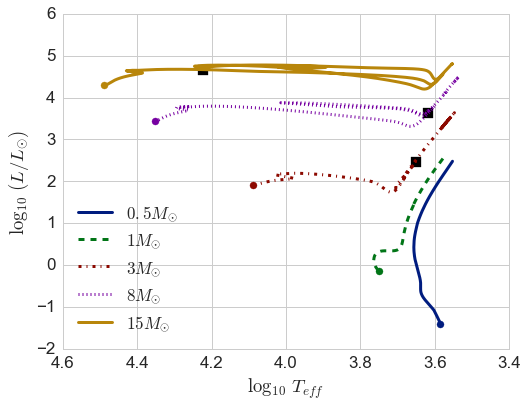

In [18]:
hr('hr_5models.png')

### Central temperature vs central density: criteria for helium ignition and core degeneracy.

In [19]:
def rhoc_tc(pngfile=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for ii, mm in enumerate(mass):
        ax.plot(rhoc[ii], tc[ii], ls=lines[ii], lw=3, color=col[ii], 
                label='${:g} M_{{\odot}}$'.format(mm))
        ax.scatter(rhoc[ii][0], tc[ii][0], marker='o', s=50, color=col[ii])
        if hecore[ii] >= 0:
            ax.scatter(rhoc[ii][hecore[ii]], tc[ii][hecore[ii]], 
                       marker='s', s=100, color='k')#col[ii])

    ax.set_xlabel(r'$\log_{10}\ \rho_{c}\ (kg\ m^{-3})$')
    ax.set_ylabel(r'$\log_{10}\ T{c}\ (K)$')
    ax.set_xlim(3, 12)
    ax.set_ylim(6.5, 10.0)
    #ax.legend(loc='upper left')#, prop={'size': 22})
    
    rhoclim = ax.get_xlim()
    tclim = ax.get_ylim()
    rhoaxis = np.linspace(rhoclim[0], rhoclim[1], 50)
    ax.plot(rhoaxis, np.polyval([-0.133, 8.9], rhoaxis), 
            ls='-', color='k', lw=2, label='Helium ignition')
    ax.plot(rhoaxis, np.log10(1261.0 * (10**rhoaxis)**(2/3)), 
            ls='--', color='gray', label='Degeneracy criterion')
    
    ax.annotate('Non-degenerate', xy=(9.3, 9.55), fontsize=14, 
                ha='center', va='center', xycoords='data',
                rotation=53)
    ax.annotate('Degenerate', xy=(9.8, 9.4), fontsize=14, 
                ha='center', va='center', xycoords='data',
                rotation=53)
    ax.annotate('Helium ignition', xy=(10.7, 7.6), fontsize=14, 
                ha='center', va='center', xycoords='data',
                rotation=-15)
   
    handles, labels = ax.get_legend_handles_labels()
    ax.add_artist(ax.legend(handles[:5], labels[:5], loc='upper left'))
    #ax.add_artist(ax.legend(handles[5:7], labels[5:7], loc='lower right'))

    if pngfile:
        fig.savefig(pngfile)

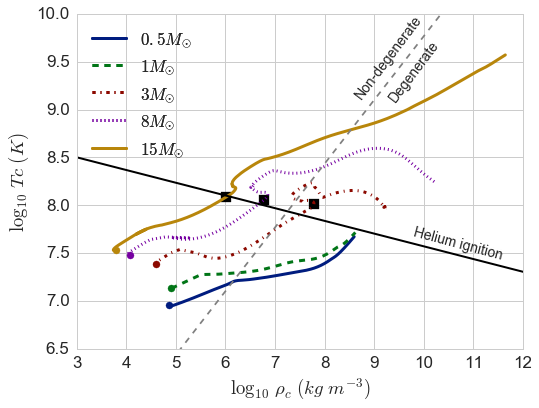

In [20]:
rhoc_tc('rho_tc_5models.png')

### Playing around...

In [215]:
if False:
    plt.scatter(age[3], rand[3])
    #plt.ylim(-10, 10)
    print(rand[3])